In [1]:
# import relevant packages
from db_queries import get_outputs, get_ids
import pandas as pd
import numpy as np
from gbd_mapping import causes, risk_factors
from vivarium_inputs import get_measure
import gbd_mapping, vivarium_inputs, scipy.stats
from operator import attrgetter
from get_draws.api import get_draws
from math import sqrt, pi

# Get global overall anemia impairment prevalence

In [2]:
# get global anemia impairment prevalence 
anemia = get_draws('rei_id', 192, source='como', measure_id=5, location_id=1, year_id=2017, gbd_round_id=5)
anemia_all = anemia.where(anemia['cause_id'] == 294).dropna()
anemia_avg = anemia_all.set_index(['age_group_id','location_id', 'measure_id', 'rei_id',
                                 'sex_id', 'year_id', 'metric_id','cause_id'])
anemia_avg['avg'] = anemia_avg.mean(axis=1)
anemia_avg = anemia_avg.reset_index()
gbd_prepped = anemia_avg[['age_group_id','sex_id','avg']]
gbd_prepped = gbd_prepped.rename(columns={'avg': 'prev'})
gbd_prepped.head()

,age_group_id,sex_id,prev
0,2.0,1.0,0.486924
1,3.0,1.0,0.485108
2,4.0,1.0,0.481013
3,5.0,1.0,0.380173
4,6.0,1.0,0.349691


# Get anemia prevalence among list of iron-responsive causes

In [3]:
# define list of anemia-afflicted sequela among list of iron-responsive causes
ira = [206,207,208, # dietary iron def
        172,173,174, #hookworm
        144,145,146, #schistosomiasis
        4952,4955,4958,4961,4964,4967,4976,4979,4982,5627,5630,5633,7202,7205,7208, #peptic ulcer disease
        4985,4988,4991,4994,4997,5000,5009,5012,5015,5678,5681,5684,7214,7217,7220, #gastritis
        1106,1107,1108, #uterine fibroids
        525,526,527, # other menstrual disorders
        1004, 1005,1006,1008,1009,1010,1012,1013,1014,1016,1017,1018,1020,1021,1022,
        1024,1025,1026,1028,1029,1030,1032,1033,1034,1361,1364,1367,1373,1376,1379,1385,
        1388,1391,1397,1400,1403,1409,1412,1415,1421,1424,1427,1433,1436,1439,1445,1448,1451,
        5213,5216,5219,5222,5225,5228,5237,5240,5243,5246,5249,5252,5261,5264,5267,5270,
        5273,5276, # chronic kidney disease
        5579,5582,5585, #crohns
        5567,5570,5573, # UC
        23030,23031,23032,23034,23035,23036,23038,23039,23040,
        23042,23043,23044,23046,23047,23048, # cirrhosis
        537,538,539, #endocrine disorders
        177,178,179, # other neglected tropical diseases
        240,241,242, # other infectious diseases
        182,183,184, # maternal hemorrhage
        5393,5396,5399] #vitamin a deficiency

In [5]:
# get iron-responsive anemia prevalence for males in age groups 4-32
    # (exclude females to avoid pregnancy adjustment issues)
    # (exclude neonatal age groups to avoid copied prevalence issues)
age_group_ids = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,31,32]
ira = get_outputs(gbd_round_id=5, year_id=2017, sex_id=1, age_group_id=age_group_ids, topic='sequela', sequela_id=ira, measure_id=5, metric_id=3)
ira.head()

,age_group_id,location_id,measure_id,metric_id,sequela_id,sex_id,year_id,age_group_name,expected,location_name,measure_name,metric_name,sequela_name,sex,val,upper,lower
0,4,1,5,3,144,1,2017,Post Neonatal,False,Global,Prevalence,Rate,Mild anemia due to schistosomiasis,Male,2.346138e-08,3.060408e-08,1.756294e-08
1,4,1,5,3,145,1,2017,Post Neonatal,False,Global,Prevalence,Rate,Moderate anemia due to schistosomiasis,Male,2.347076e-08,3.328022e-08,1.703880e-08
2,4,1,5,3,146,1,2017,Post Neonatal,False,Global,Prevalence,Rate,Severe anemia due to schistosomiasis,Male,2.354539e-08,3.532412e-08,1.606189e-08
3,4,1,5,3,172,1,2017,Post Neonatal,False,Global,Prevalence,Rate,Mild anemia due to hookworm disease,Male,5.110801e-05,5.931064e-05,4.139125e-05
4,4,1,5,3,173,1,2017,Post Neonatal,False,Global,Prevalence,Rate,Moderate anemia due to hookworm disease,Male,8.990573e-05,1.040916e-04,7.786159e-05


In [6]:
# sum across all sequela for total iron-responsive anemia prevalence among each age group
ira_summed = ira.groupby('age_group_id').sum()
ira_summed = ira_summed.reset_index()
ira_summed.head()

,age_group_id,location_id,measure_id,metric_id,sequela_id,sex_id,year_id,val,upper,lower
0,4,147,735,441,724608,147,296499,0.447832,0.515968,0.383716
1,5,147,735,441,724608,147,296499,0.349469,0.401087,0.307298
2,6,147,735,441,724608,147,296499,0.322704,0.383895,0.274616
3,7,147,735,441,724608,147,296499,0.176817,0.219204,0.143754
4,8,147,735,441,724608,147,296499,0.202367,0.236968,0.176276


# Get means and standard deviation for the iron deficiency risk factor

In [7]:
# get means of hemoglobin distribution among iron-responsive causes from REI ID
mean = get_draws('rei_id', 95, source='exposure', location_id=1, year_id=2017, gbd_round_id=5)
mean_slim = mean.drop(columns=['location_id','measure_id','metric_id','modelable_entity_id','year_id'])
mean_slim = mean_slim.set_index(['age_group_id','sex_id'])
mean_slim['avg'] = mean_slim.mean(axis=1)
mean_fin = mean_slim.reset_index()
mean_fin = mean_fin[['age_group_id','sex_id','avg']]
mean_fin = mean_fin.rename(columns={'avg': 'mean'})
mean_fin.head()

,age_group_id,sex_id,mean
0,2,1,119.760815
1,3,1,119.529761
2,4,1,110.721191
3,5,1,114.554646
4,6,1,120.924580


In [8]:
# get means of hemoglobin distribution among iron-responsive causes from modelable entity #10487
    # NOTE these values are nearly the same, but off by a few decimal points
    # compared to the REI ID means
mean_mod = get_draws('modelable_entity_id', 10487, source='epi', location_id=1, year_id=2017, gbd_round_id=5)
mean_mod_slim = mean_mod.drop(columns=['location_id','measure_id','metric_id','modelable_entity_id','year_id','model_version_id'])
mean_mod_slim = mean_mod_slim.set_index(['age_group_id','sex_id'])
mean_mod_slim['avg'] = mean_mod_slim.mean(axis=1)
mean_mod_fin = mean_mod_slim.reset_index()
mean_mod_fin = mean_mod_fin[['age_group_id','sex_id','avg']]
mean_mod_fin = mean_mod_fin.rename(columns={'avg': 'mean'})
mean_mod_fin.head()

,age_group_id,sex_id,mean
0,2,1,119.340210
1,3,1,119.095491
2,4,1,110.063560
3,5,1,114.417665
4,6,1,120.890217


In [9]:
# get standard deviation of hemoglobin distribution among iron-responsive causes 
sd = get_draws('modelable_entity_id', 10488, source='epi', location_id=1, year_id=2017, gbd_round_id=5)
sd_slim = sd.drop(columns=['location_id','measure_id','metric_id','modelable_entity_id','year_id','model_version_id'])
sd_slim = sd_slim.set_index(['age_group_id','sex_id'])
sd_slim['avg'] = sd_slim.mean(axis=1)
sd_fin = sd_slim.reset_index()
sd_fin = sd_fin[['age_group_id','sex_id','avg']]
sd_fin = sd_fin.rename(columns={'avg': 'sd'})
sd_fin.head()

,age_group_id,sex_id,sd
0,2,1,14.941291
1,3,1,13.771568
2,4,1,13.795606
3,5,1,13.160807
4,6,1,13.369719


In [10]:
# combine means and sds
merged = gbd_prepped.merge(mean_fin, right_on=['age_group_id','sex_id'], left_on=['age_group_id','sex_id'])
merged = merged.merge(sd_fin, right_on=['age_group_id','sex_id'], left_on=['age_group_id','sex_id'])
merged.head()

,age_group_id,sex_id,prev,mean,sd
0,2.0,1.0,0.486924,119.760815,14.941291
1,3.0,1.0,0.485108,119.529761,13.771568
2,4.0,1.0,0.481013,110.721191,13.795606
3,5.0,1.0,0.380173,114.554646,13.160807
4,6.0,1.0,0.349691,120.924580,13.369719


# Recreate iron-responsive anemia prevalence based on ensemble distribution/iron deficiency risk factor

In [11]:
# define constants
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
XMAX = 220
gamma_w = 0.4
m_gum_w = 0.6

In [12]:
# define anemia cut points
merged['mild_anemia_cut'] = np.where(merged['sex_id'] == 1, 130, 120)
merged['mild_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 150,
                               np.where(merged['age_group_id'].isin([4,5]), 110,
                                       np.where(merged['age_group_id'].isin([6,7]), 115, merged['mild_anemia_cut'])))

# define gamma distribution parameters
merged['gamma_shape'] = (merged['mean'] ** 2) / (merged['sd']**2)
merged['gamma_rate'] = merged['mean'] / (merged['sd']**2)

# define mirror gumbel distribution parameters
merged['mgum_alpha'] = XMAX - merged['mean'] - EULERS_CONSTANT*merged['sd']*sqrt(6)/pi
merged['mgum_scale'] = merged['sd']*sqrt(6)/pi

# calculate probability of anemia based on normal and ensesmble distribution assumptions
merged['normal_dist_prev'] = scipy.stats.norm(merged['mean'], 
                                merged['sd']).cdf(merged['mild_anemia_cut'])
merged['gamma_dist_prev'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mild_anemia_cut'])
merged['mir_gum_dist_prev'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mild_anemia_cut'])
merged['ensemble_dist_prev']= gamma_w*merged['gamma_dist_prev'] + m_gum_w*merged['mir_gum_dist_prev']
merged.head()

,age_group_id,sex_id,prev,mean,sd,mild_anemia_cut,gamma_shape,gamma_rate,mgum_alpha,mgum_scale,normal_dist_prev,gamma_dist_prev,mir_gum_dist_prev,ensemble_dist_prev
0,2.0,1.0,0.486924,119.760815,14.941291,150,64.247061,0.536461,93.514809,11.649676,0.978508,0.972299,0.999462,0.988596
1,3.0,1.0,0.485108,119.529761,13.771568,150,75.333009,0.630245,94.272300,10.737648,0.986536,0.981511,0.999931,0.992563
2,4.0,1.0,0.481013,110.721191,13.795606,110,64.413949,0.581767,103.070052,10.756390,0.479154,0.495683,0.408474,0.443358
3,5.0,1.0,0.380173,114.554646,13.160807,110,75.763560,0.661375,99.522291,10.261439,0.364643,0.377392,0.302468,0.332438
4,6.0,1.0,0.349691,120.924580,13.369719,115,81.805893,0.676503,93.058335,10.424328,0.328834,0.339595,0.272431,0.299297


In [13]:
# select males with age_group_ids 4 - 32 for comparison/plots
    # (exclude females due to pregnancy adjustment)
    # (exclude age groups #2,3 due to copied anemia prevalence)
prepped = merged.where(merged['sex_id'] == 1).dropna()
prepped = prepped.where(prepped['age_group_id'].isin(list(range(4, 33)))).dropna()

Text(0, 0.5, 'Prevalence Proportion')

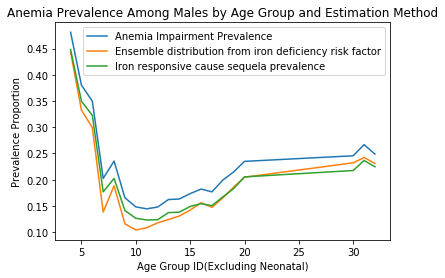

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(prepped['age_group_id'],prepped['prev'])
plt.plot(prepped['age_group_id'],prepped['ensemble_dist_prev'])
plt.plot(ira_summed['age_group_id'],ira_summed['val'])

plt.legend(['Anemia Impairment Prevalence','Ensemble distribution from iron deficiency risk factor',
            'Iron responsive cause sequela prevalence','Anemia impairment with deleted iron responsive sequela prevalence'])
plt.title('Anemia Prevalence Among Males by Age Group and Estimation Method')
plt.xlabel('Age Group ID(Excluding Neonatal)')
plt.ylabel('Prevalence Proportion')

## Conclusion

Ensemble distribution anemia prevalence recreation results in a lower prevalence than the anemia prevalence from iron-responsive cause anemia prevalence from get_outputs. This may be because of COMO adjustments.